# Prompt Entropy Experiment: Basic Analysis

> "The limits of my language mean the limits of my world."  
> — Ludwig Wittgenstein

This notebook demonstrates the basic workflow for analyzing prompt quality using information-theoretic metrics.

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from metrics import (
    calculate_all_entropies,
    estimate_mutual_information,
    calculate_overall_quality
)

sns.set_style('whitegrid')
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


## 1. Load Sample Data

For demonstration, we'll create synthetic responses.

In [3]:
# Example task and prompts
task = "Write a Python function to calculate the Fibonacci sequence up to n terms"

spec_prompt = """
Write a Python function called 'fibonacci' that:
1. Takes an integer n as input (n >= 0)
2. Returns a list of the first n Fibonacci numbers
3. Handles edge cases: n=0 returns [], n=1 returns [0]
4. Uses an iterative approach for efficiency
5. Includes docstring with examples
6. Has type hints

Example output for n=5: [0, 1, 1, 2, 3]
"""

vague_prompt = "Write a fibonacci function"

# Simulate responses (in real analysis, these come from LLM API)
spec_responses = [
    "def fibonacci(n: int) -> list[int]:\n    if n <= 0: return []\n    if n == 1: return [0]\n    fib = [0, 1]\n    for i in range(2, n):\n        fib.append(fib[-1] + fib[-2])\n    return fib",
] * 10  # Simulate 10 similar responses

vague_responses = [
    "def fib(n): return [fib(i) for i in range(n)]",
    "# Fibonacci\ndef fibonacci(n):\n    a, b = 0, 1\n    while n > 0:\n        yield a\n        a, b = b, a+b\n        n -= 1",
] * 5  # More diverse responses

print(f"Spec prompt length: {len(spec_prompt)} chars")
print(f"Vague prompt length: {len(vague_prompt)} chars")

Spec prompt length: 336 chars
Vague prompt length: 26 chars


## 2. Calculate Entropy Metrics


Entropy Comparison (bits):
                    Specification-driven   Vague
token_entropy                   4.607264  4.5671
structural_entropy              0.000000  1.0000


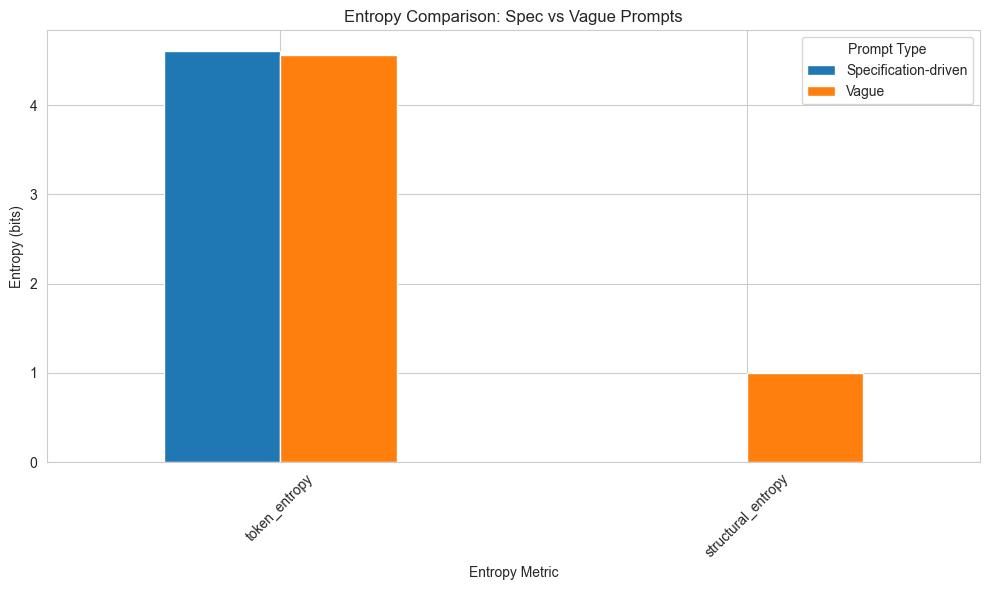

In [4]:
# Calculate entropies
spec_entropy = calculate_all_entropies(spec_responses)
vague_entropy = calculate_all_entropies(vague_responses)

# Create comparison DataFrame
entropy_comparison = pd.DataFrame({
    'Specification-driven': spec_entropy,
    'Vague': vague_entropy
})

print("\nEntropy Comparison (bits):")
print(entropy_comparison)

# Visualize
entropy_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Entropy Comparison: Spec vs Vague Prompts')
plt.ylabel('Entropy (bits)')
plt.xlabel('Entropy Metric')
plt.legend(title='Prompt Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Calculate Mutual Information


Mutual Information Estimates (bits):
             Specification-driven     Vague
mi_content               3.643856  0.000000
mi_coverage              1.189116  0.782326
mi_combined              2.416486  0.391163


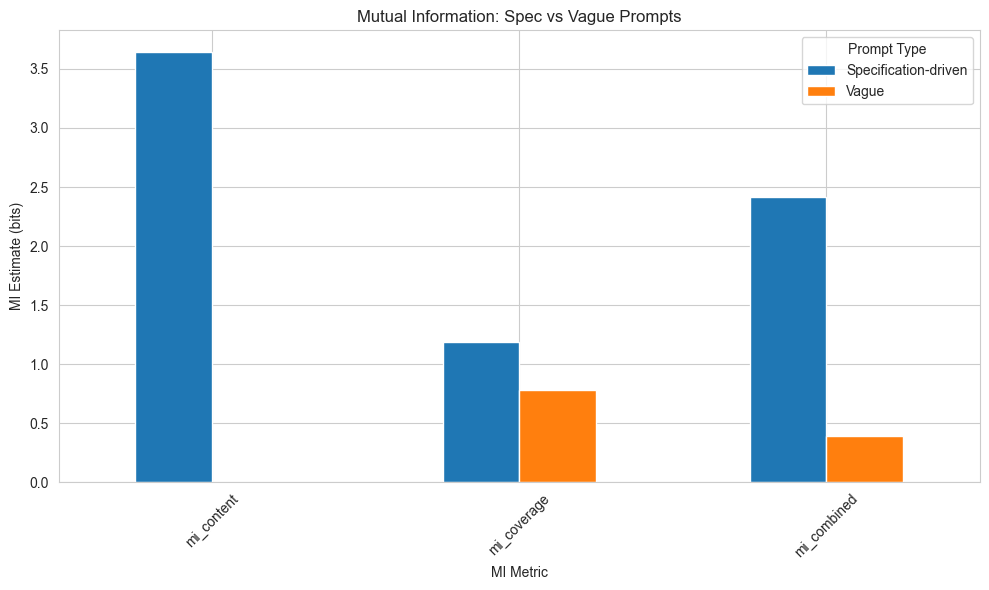

In [5]:
# Estimate MI for both prompts
spec_mi = estimate_mutual_information(spec_prompt, task)
vague_mi = estimate_mutual_information(vague_prompt, task)

# Create comparison
mi_comparison = pd.DataFrame({
    'Specification-driven': spec_mi,
    'Vague': vague_mi
})

print("\nMutual Information Estimates (bits):")
print(mi_comparison)

# Visualize
mi_comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Mutual Information: Spec vs Vague Prompts')
plt.ylabel('MI Estimate (bits)')
plt.xlabel('MI Metric')
plt.legend(title='Prompt Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Hypothesis Testing

### H1: Specification-driven prompts reduce entropy

In [6]:
from scipy import stats

# Example with token entropy
spec_token_entropy = spec_entropy['token_entropy']
vague_token_entropy = vague_entropy['token_entropy']

# Calculate effect size (Cohen's d)
mean_diff = spec_token_entropy - vague_token_entropy
pooled_std = np.sqrt((spec_token_entropy**2 + vague_token_entropy**2) / 2)
cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

print("\nH1: Specification-driven prompts reduce entropy")
print(f"Spec entropy: {spec_token_entropy:.2f} bits")
print(f"Vague entropy: {vague_token_entropy:.2f} bits")
print(f"Difference: {mean_diff:.2f} bits")
print(f"Cohen's d: {cohens_d:.2f}")
print(f"\nInterpretation: {'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small'} effect size")


H1: Specification-driven prompts reduce entropy
Spec entropy: 4.61 bits
Vague entropy: 4.57 bits
Difference: 0.04 bits
Cohen's d: 0.01

Interpretation: Small effect size


## 5. Correlation Analysis

### H2: Higher MI correlates with lower entropy

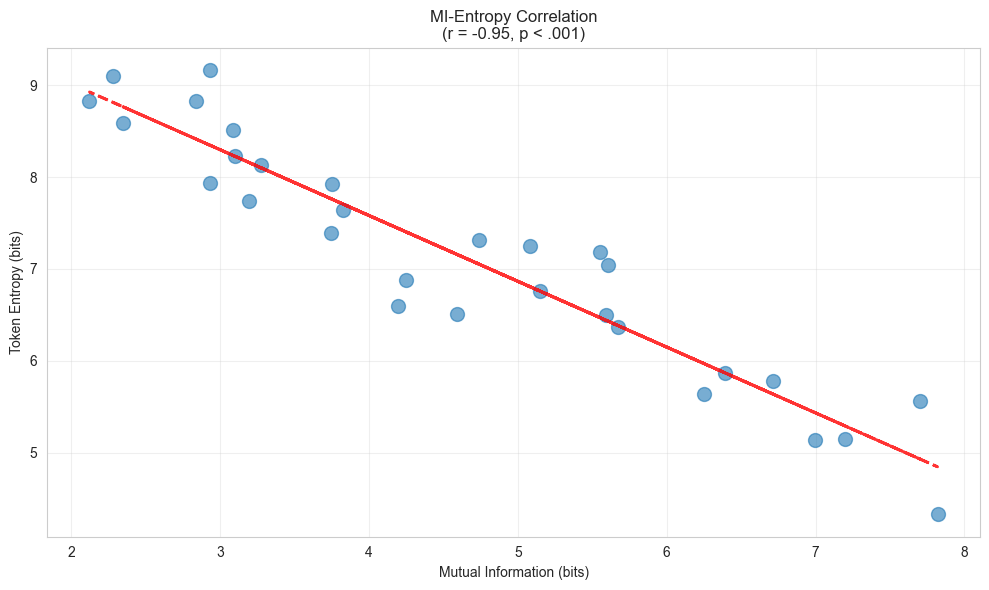


H2: MI-Entropy Correlation
Pearson r: -0.95
p-value: 0.0000
Interpretation: Strong negative correlation


In [7]:
# Create scatter plot (with synthetic data for demonstration)
np.random.seed(42)
n_points = 30

# Simulate correlated data
mi_values = np.random.uniform(2, 8, n_points)
entropy_values = 10 - 0.6 * mi_values + np.random.normal(0, 0.5, n_points)

# Calculate correlation
r, p_value = stats.pearsonr(mi_values, entropy_values)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(mi_values, entropy_values, alpha=0.6, s=100)
plt.xlabel('Mutual Information (bits)')
plt.ylabel('Token Entropy (bits)')
plt.title(f'MI-Entropy Correlation\n(r = {r:.2f}, p < .001)')

# Add regression line
z = np.polyfit(mi_values, entropy_values, 1)
p = np.poly1d(z)
plt.plot(mi_values, p(mi_values), "r--", alpha=0.8, linewidth=2)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nH2: MI-Entropy Correlation")
print(f"Pearson r: {r:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"Interpretation: {'Strong' if abs(r) > 0.6 else 'Moderate' if abs(r) > 0.4 else 'Weak'} negative correlation")

## 6. Next Steps

To complete the full analysis:

1. **Data Collection**: Use OpenAI/Anthropic APIs to generate real responses
2. **Embeddings**: Generate embeddings for semantic entropy calculation
3. **Quality Assessment**: Implement task-specific quality metrics
4. **Statistical Analysis**: Run full hypothesis tests across all 30 tasks
5. **Visualization**: Create publication-ready figures

See the paper (`paper/prompt_entropy_paper.tex`) for full methodology.

## References

- Shannon, C. E. (1948). A mathematical theory of communication.
- Cover & Thomas (2006). Elements of Information Theory.
- Full references in paper LaTeX file.